<a href="https://colab.research.google.com/github/Harinijuluru/Explainable-AI/blob/main/sepsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install lime pdpbox shap scikit-learn matplotlib seaborn tensorflow plotly --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import shap
from lime.lime_tabular import LimeTabularExplainer
from pdpbox import pdp, info_plots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [4]:
df = pd.read_csv('/content/Sepsis_Dataset.csv')
print(df.shape)
df.head()

(100, 21)


,Age,HeartRate,SystolicBP,DiastolicBP,RespiratoryRate,Temperature,SpO2,WBC,Platelets,Creatinine,...,Glucose,CRP,Bilirubin,Diabetes,Hypertension,ChronicHeartDisease,ChronicKidneyDisease,Immunocompromised,RecentSurgery,SepsisLabel
0,62,80.639568,117.492474,81.656751,13.168589,36.684806,99.700686,5.281007,206.932393,0.451069,...,112.049544,13.531637,1.038577,1,1,1,0,0,1,0
1,23,99.809272,109.023575,58.790112,17.890190,37.823022,82.348350,19.172710,85.463574,1.235118,...,174.689056,167.144421,2.292486,0,1,0,0,0,0,1
2,85,68.120872,113.236212,72.047150,15.084069,36.202384,99.438068,2.650430,287.913032,0.815585,...,74.673190,41.151663,1.008518,0,1,0,1,0,0,0
3,66,96.012591,82.222026,69.611044,23.685073,38.299557,91.821980,11.420220,226.280756,2.659419,...,198.917426,130.217598,2.764322,0,1,0,0,0,0,1
4,27,105.852354,106.577727,50.398946,25.794595,39.451172,92.831735,12.892347,129.968545,2.237659,...,164.350158,145.524325,1.765381,0,1,0,0,0,0,1


In [8]:
# Handle missing values
df = df.dropna()


# Define features and target
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']


# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
# Reshape input for LSTM: (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)


model = Sequential([
LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
Dense(32, activation='relu'),
Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=16, validation_split=0.2)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5938 - loss: 0.6886 - val_accuracy: 0.8125 - val_loss: 0.6693
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9646 - loss: 0.6520 - val_accuracy: 1.0000 - val_loss: 0.6343
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.6141 - val_accuracy: 1.0000 - val_loss: 0.5961
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.5776 - val_accuracy: 1.0000 - val_loss: 0.5562
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.5415 - val_accuracy: 1.0000 - val_loss: 0.5132
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.5027 - val_accuracy: 1.0000 - val_loss: 0.4664
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.4558 - val_accuracy: 1.0000 - val_loss: 0.4169
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.4141 - val_accuracy: 1.0000 - val_loss: 0.3668

In [10]:
y_pred = (model.predict(X_test_lstm) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
[[ 5  0]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        15

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


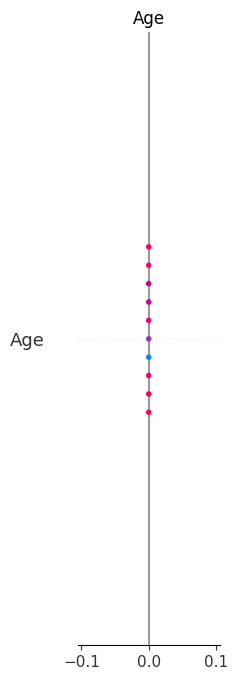

In [53]:
def predict_wrapper(x):
  return model.predict(np.expand_dims(x, axis=1))

explainer = shap.KernelExplainer(predict_wrapper, X_train[:10])
shap_values = explainer.shap_values(X_test[:10])


# Summary plot
shap.summary_plot(shap_values, features=X_test[:10], feature_names=X.columns)

In [54]:
explainer = LimeTabularExplainer(
training_data=np.array(X_train),
feature_names=X.columns,
class_names=['No Sepsis', 'Sepsis'],
mode='classification'
)


i = 0 # Choose one sample
exp = explainer.explain_instance(
data_row=X_test[i],
predict_fn=lambda x: np.hstack([1 - model.predict(np.expand_dims(x, axis=1)), model.predict(np.expand_dims(x, axis=1))])
)
exp.show_in_notebook(show_table=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [55]:
!pip install scikeras --quiet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
---- IPE Report (combined SHAP + LIME) ----


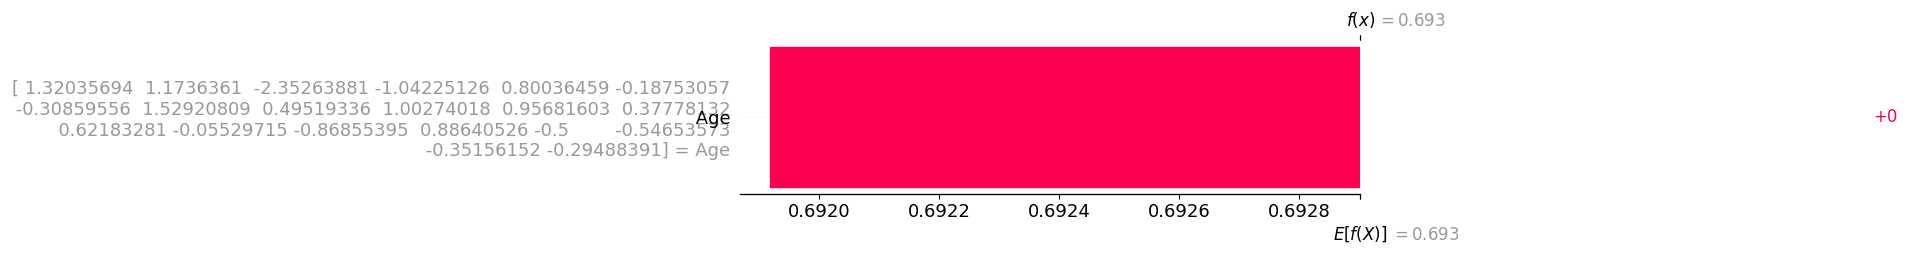

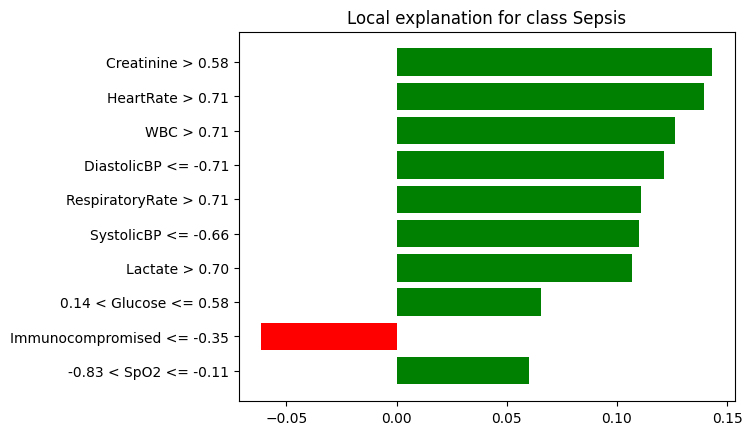

In [56]:
def predict_wrapper(x):
  return model.predict(np.expand_dims(x, axis=1))

i = 0
sample = X_test[i].reshape(1, -1)
explainer = shap.KernelExplainer(predict_wrapper, X_train[:10])
shap_values = explainer.shap_values(sample)

# Create LIME explainer and explain instance
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['No Sepsis', 'Sepsis'],
    mode='classification'
)
exp = explainer_lime.explain_instance(
    data_row=X_test[i],
    predict_fn=lambda x: np.hstack([1 - model.predict(np.expand_dims(x, axis=1)), model.predict(np.expand_dims(x, axis=1))])
)


print("---- IPE Report (combined SHAP + LIME) ----")
# Convert shap_values to Explanation object
shap_explanation = shap.Explanation(values=shap_values[0][0], base_values=explainer.expected_value[0], data=sample, feature_names=X.columns)
shap.plots.waterfall(shap_explanation)
exp.as_pyplot_figure()
plt.show()

Loaded (100, 21) columns: ['Age', 'HeartRate', 'SystolicBP', 'DiastolicBP', 'RespiratoryRate', 'Temperature', 'SpO2', 'WBC', 'Platelets', 'Creatinine', 'Lactate', 'Glucose', 'CRP', 'Bilirubin', 'Diabetes', 'Hypertension', 'ChronicHeartDisease', 'ChronicKidneyDisease', 'Immunocompromised', 'RecentSurgery', 'SepsisLabel']
Found label column: SepsisLabel
Numeric columns used: 19 Categorical columns used: 0
Class distribution:
 SepsisLabel
1    70
0    30
Name: count, dtype: int64


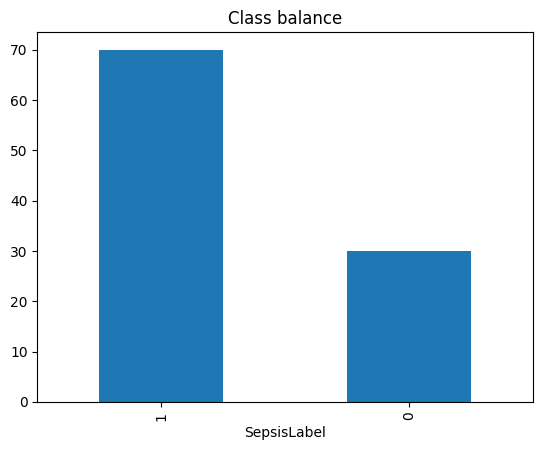

Applying SMOTE to training set later if needed (demonstration)
After SMOTE: SepsisLabel
1    53
0    53
Name: count, dtype: int64

--- Model: random_forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        17

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Confusion matrix:
 [[ 8  0]
 [ 0 17]]
ROC AUC: 1.0

--- Model: xgboost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        17

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Confusion matrix:
 [[ 8  0]
 [ 0 17]]
ROC AUC: 1.0


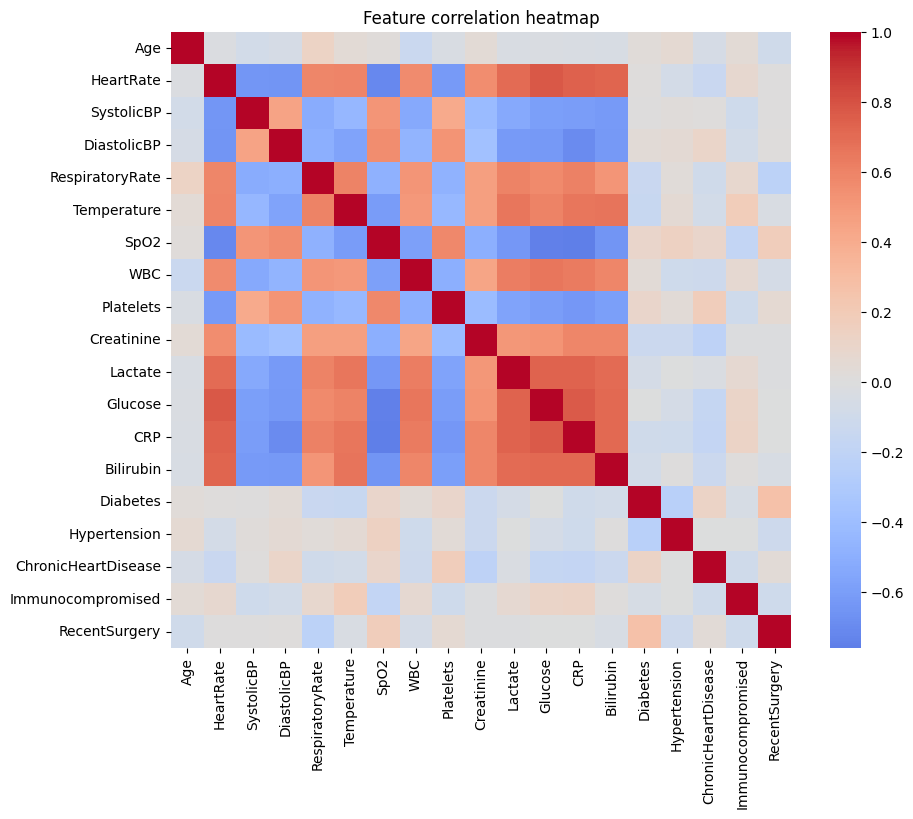

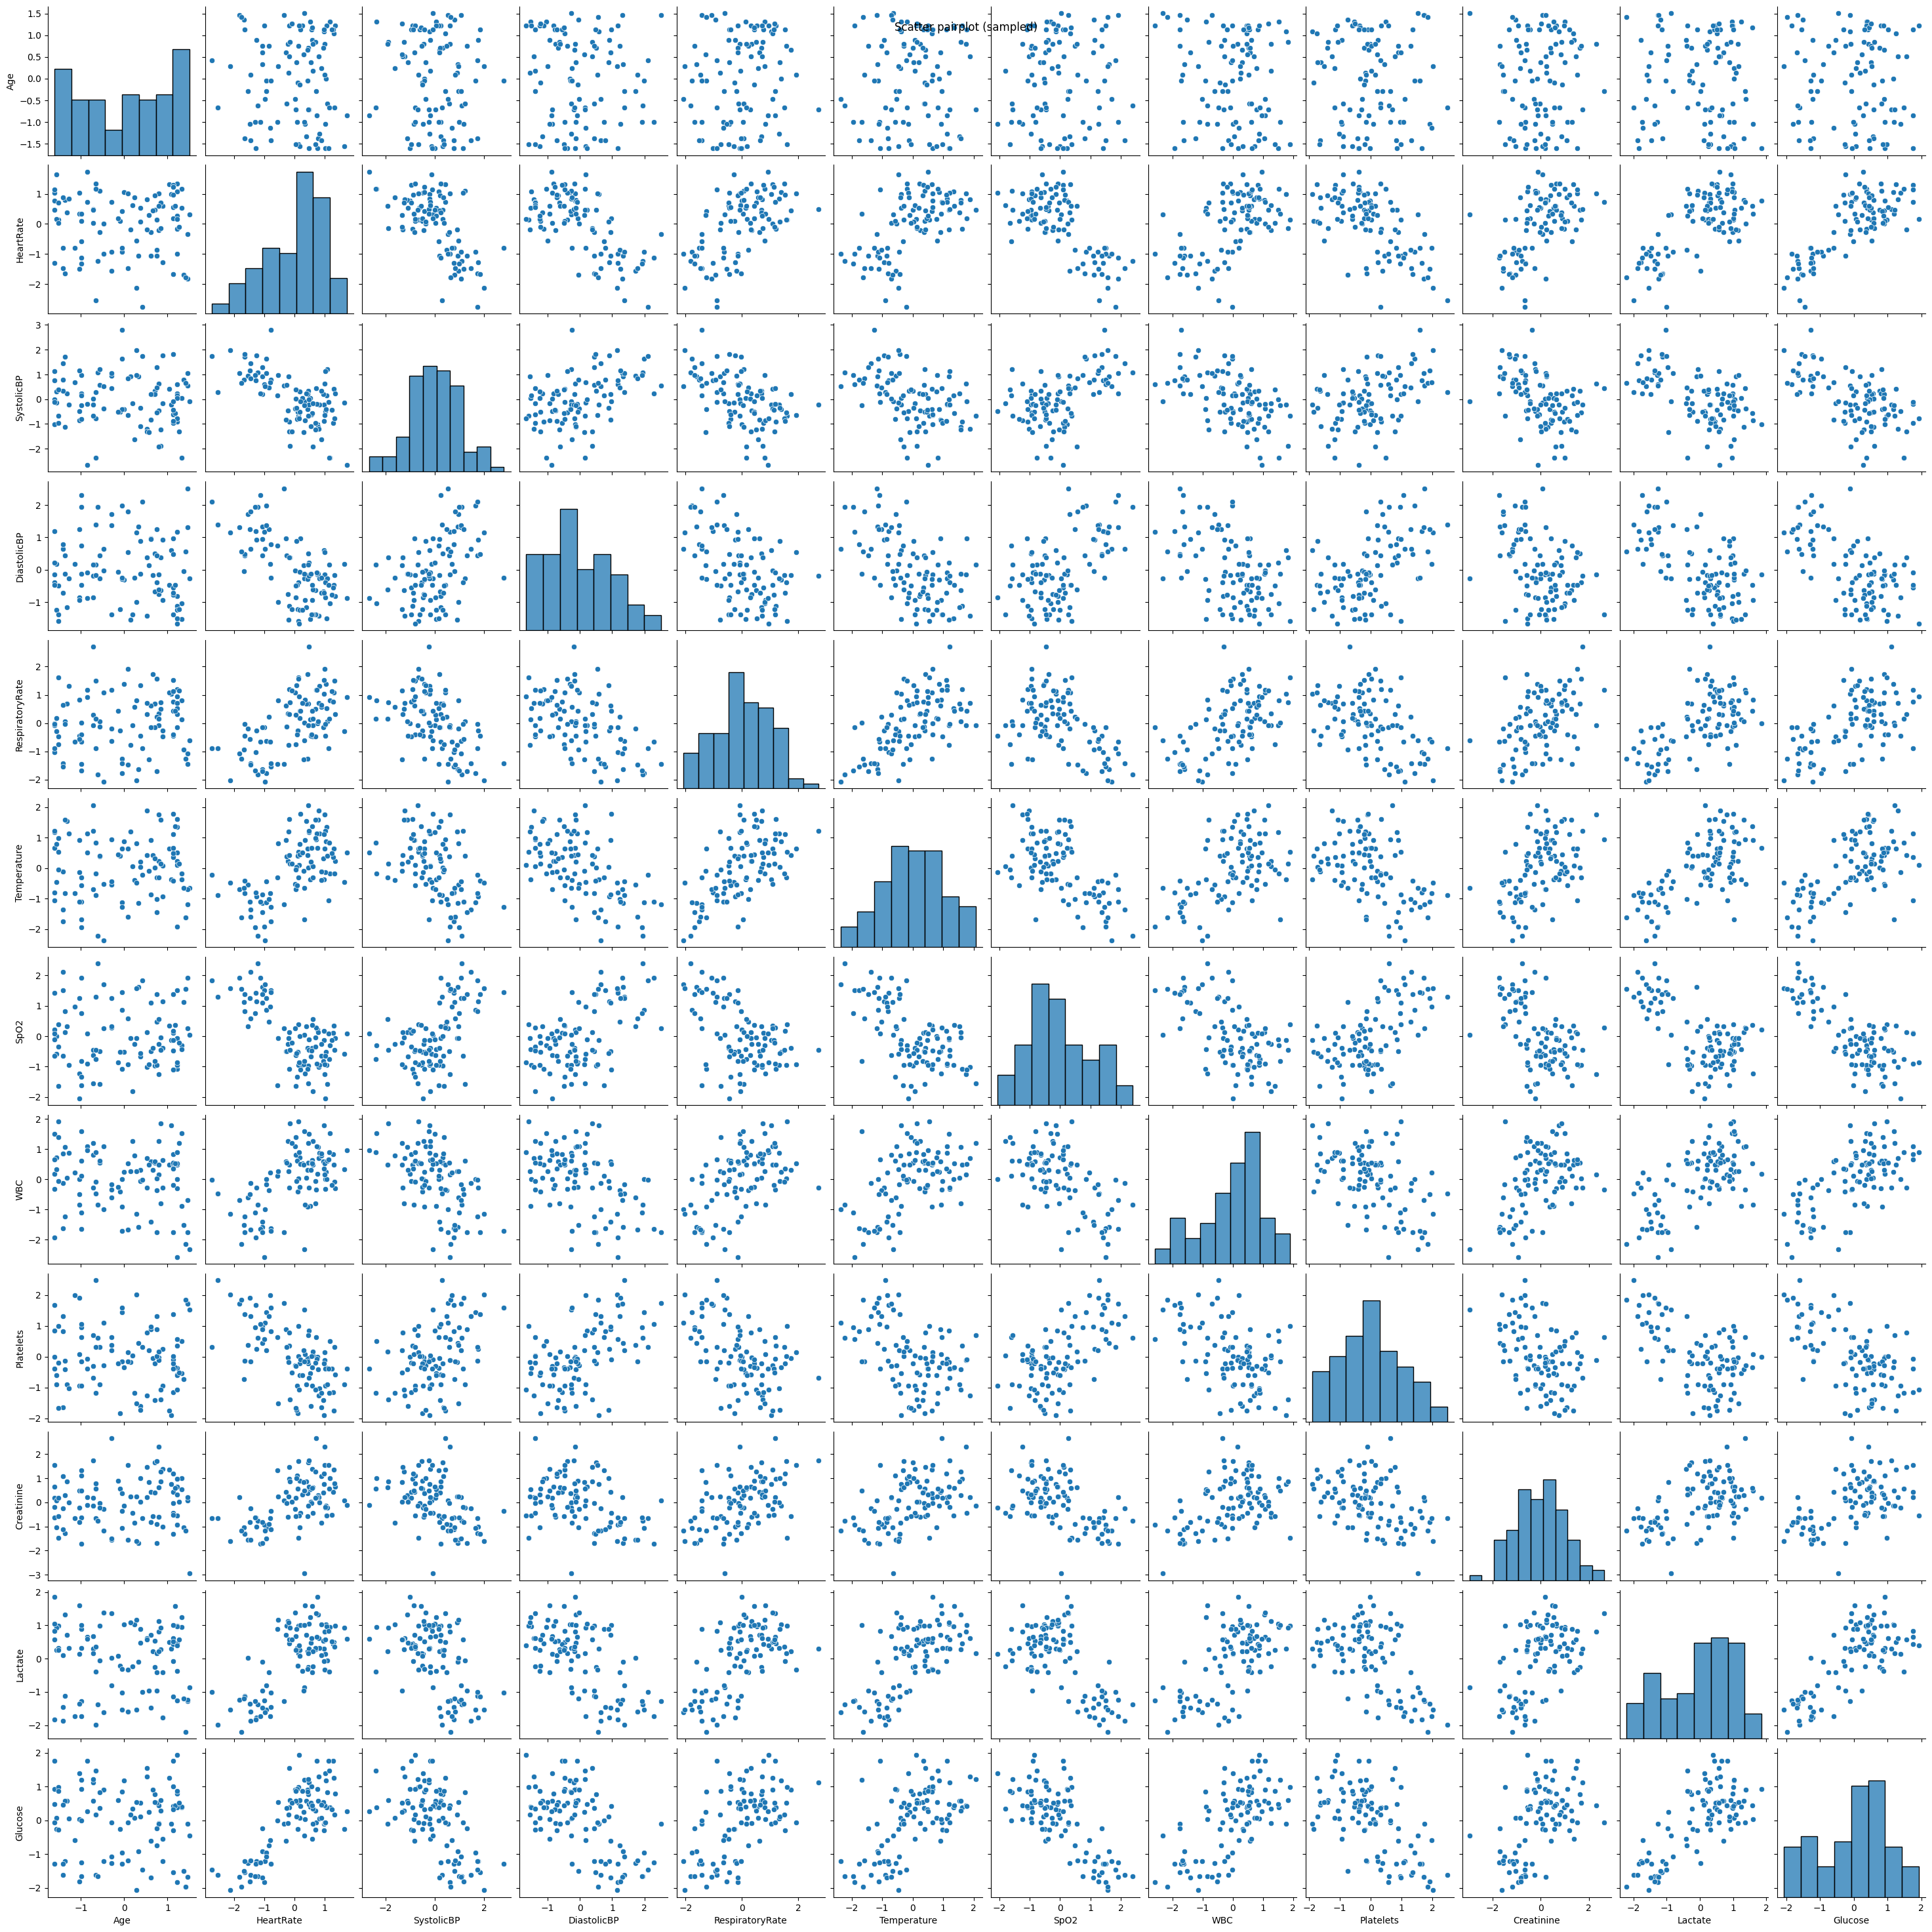

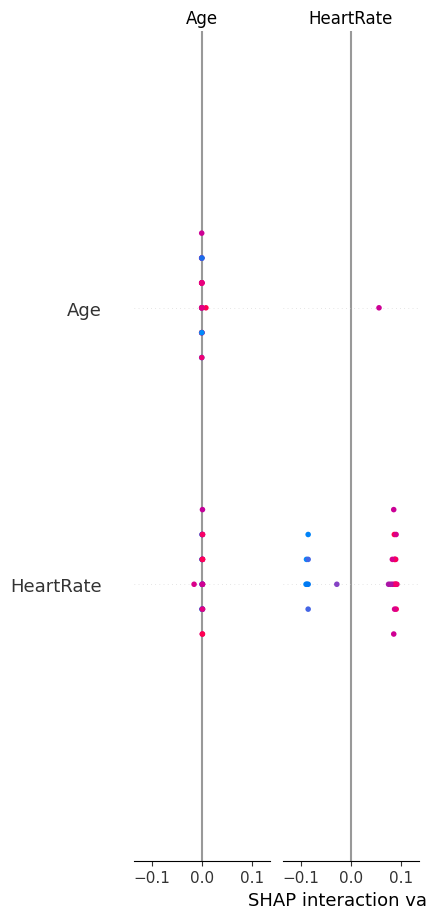

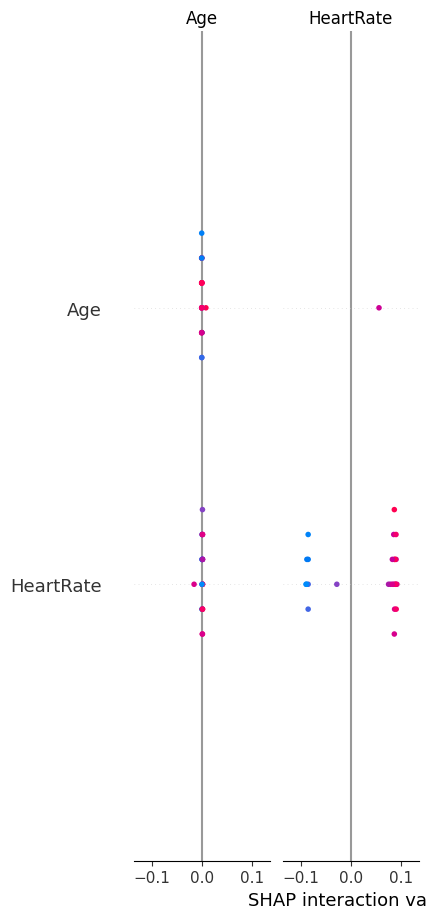

LIME explanation for test instance 0:
[('-0.65 < CRP <= 0.54', 0.17812447541867324), ('-0.46 < HeartRate <= 0.60', 0.11627305742746101), ('Bilirubin > 0.49', 0.08666858905788834), ('SpO2 <= -0.49', 0.07654587786724189), ('-0.40 < Glucose <= 0.45', 0.0540566343205687), ('-0.53 < Temperature <= 0.39', 0.042049061912628145), ('-1.33 < Lactate <= -0.25', -0.02572570716018792), ('Creatinine > 0.39', 0.021488367374241504), ('SystolicBP <= -0.41', 0.019624283985237283), ('RecentSurgery <= -0.29', -0.013567515329803779)]


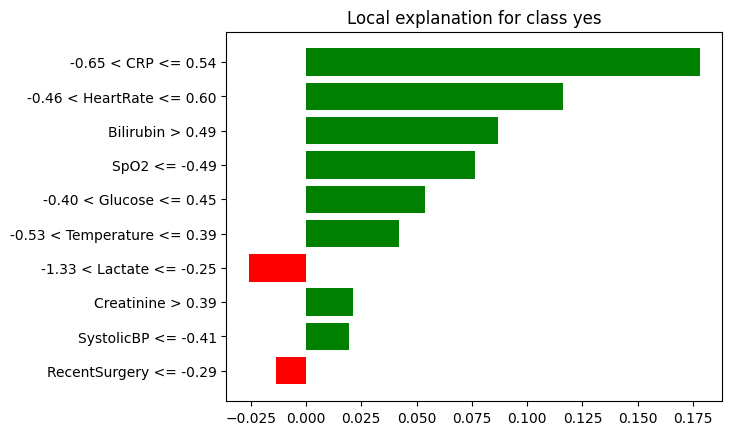

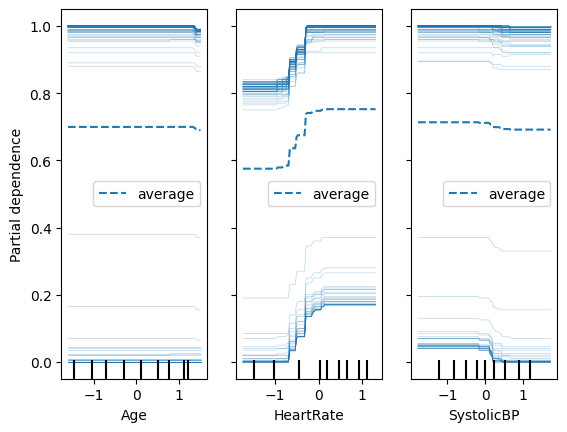

In [58]:
# Sepsis_XAI_pipeline.py
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Optional packages (may need pip install)
try:
    import shap
except Exception as e:
    print('shap not installed:', e)

try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception as e:
    print('lime not installed:', e)

try:
    import xgboost as xgb
except Exception as e:
    xgb = None
    print('xgboost missing:', e)

try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    SMOTE = None
    print('imbalanced-learn (SMOTE) missing:', e)

try:
    from pdpbox import pdp
except Exception as e:
    pdp = None
    print('pdpbox missing (ICE/PDP helpers):', e)

# ---------- Config ----------
DATA_PATH = '/content/Sepsis_Dataset.csv'
RANDOM_STATE = 42

def load_data(path=DATA_PATH):
    df = pd.read_csv(path)
    print('Loaded', df.shape, 'columns:', list(df.columns[:30]))
    return df

# ---------- Label creation / detection ----------

def detect_or_create_label(df):
    # Candidate label names
    label_candidates = ['SepsisLabel','sepsis','Sepsis','Sepsis_flag','Label','label','sepsis_label']
    for c in label_candidates:
        if c in df.columns:
            print('Found label column:', c)
            return df, c

    # Try common clinical features for rule-based label
    clinical_cols = {
        'lactate': ['lactate','Lactate','LactateValue','lactate_level'],
        'wbc': ['WBC','Wbc','wbc','white_blood_cell_count','WBC_Count'],
        'temp': ['Temperature','temp','Temp_C','Temp'],
        'hr': ['HeartRate','HR','heart_rate','pulse'],
        'rr': ['RespRate','RR','resp_rate'],
        'sbp': ['SBP','SystolicBP','Systolic_BP']
    }

    # helper to find first available column name
    def find_first(names):
        for n in names:
            if n in df.columns:
                return n
        return None

    lact_col = find_first(clinical_cols['lactate'])
    wbc_col = find_first(clinical_cols['wbc'])
    temp_col = find_first(clinical_cols['temp'])
    hr_col = find_first(clinical_cols['hr'])
    rr_col = find_first(clinical_cols['rr'])

    if any([lact_col, wbc_col, temp_col, hr_col, rr_col]):
        print('Creating rule-based sepsis flag using available clinical columns')
        conds = []
        if lact_col:
            conds.append(df[lact_col] > 2)
        if wbc_col:
            conds.append(df[wbc_col] > 12)
        if temp_col:
            conds.append(df[temp_col] > 38)
        if hr_col:
            conds.append(df[hr_col] > 100)
        if rr_col:
            conds.append(df[rr_col] > 20)
        if conds:
            combined = np.logical_or.reduce(conds)
            df['sepsis_flag'] = combined.astype(int)
            return df, 'sepsis_flag'

    # Final fallback: unsupervised split (KMeans) to create a binary label
    print('No obvious label or clinical columns found. Creating proxy label using clustering.')
    from sklearn.cluster import KMeans
    numeric = df.select_dtypes(include=[np.number]).fillna(0)
    # reduce to a handful of cols
    cols = numeric.columns[:10]
    km = KMeans(n_clusters=2, random_state=RANDOM_STATE)
    clusters = km.fit_predict(numeric[cols])
    # choose smaller cluster as positive
    vals, counts = np.unique(clusters, return_counts=True)
    positive_cluster = vals[np.argmin(counts)]
    df['sepsis_flag'] = (clusters == positive_cluster).astype(int)
    return df, 'sepsis_flag'

# ---------- Preprocessing ----------

def preprocess(df, label_col):
    # Drop non-informative columns like IDs and timestamps heuristically
    drop_candidates = [c for c in df.columns if 'id' in c.lower() or 'timestamp' in c.lower() or 'time'==c.lower()]
    df2 = df.drop(columns=[c for c in drop_candidates if c in df.columns], errors='ignore').copy()

    # Separate X and y
    y = df2[label_col].astype(int)
    X = df2.drop(columns=[label_col])

    # Select numeric features (you can extend encoding for categoricals)
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    print('Numeric columns used:', len(num_cols), 'Categorical columns used:', len(cat_cols))

    # Impute numeric
    num_imputer = SimpleImputer(strategy='median')
    X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols)

    # Encode categorical with one-hot (if any)
    if cat_cols:
        X_cat = pd.get_dummies(X[cat_cols].fillna('missing'))
        X_proc = pd.concat([X_num, X_cat], axis=1)
    else:
        X_proc = X_num

    # Scale
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_proc), columns=X_proc.columns, index=X_proc.index)

    return X_scaled, y, scaler

# ---------- Modeling ----------

def train_models(X_train, y_train):
    models = {}
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    rf.fit(X_train, y_train)
    models['random_forest'] = rf

    if xgb is not None:
        xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
        xgb_clf.fit(X_train, y_train)
        models['xgboost'] = xgb_clf

    return models

# ---------- Evaluation ----------

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        pass
    print(classification_report(y_test, y_pred))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    if y_proba is not None:
        print('ROC AUC:', roc_auc_score(y_test, y_proba))

# ---------- SHAP explanation ----------

def shap_explain(model, X_train, X_test, max_display=10):
    try:
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        # summary
        shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=max_display)
        shap.summary_plot(shap_values, X_test, max_display=max_display)
    except Exception as e:
        print('SHAP explanation failed:', e)

# ---------- LIME explanation ----------

def lime_explain(model, X_train, X_test, feature_names=None, num_features=10):
    try:
        explainer = LimeTabularExplainer(training_data=np.array(X_train), feature_names=feature_names or X_train.columns.tolist(), class_names=['no','yes'], mode='classification')
        i = 0
        exp = explainer.explain_instance(X_test.iloc[i].values, model.predict_proba, num_features=num_features)
        print('LIME explanation for test instance 0:')
        print(exp.as_list())
        fig = exp.as_pyplot_figure()
        plt.show()
    except Exception as e:
        print('LIME explanation failed:', e)

# ---------- ICE / PDP ----------

def ice_pdp_plot(model, X, features):
    try:
        # sklearn PartialDependenceDisplay (ICE if kind='individual' or 'both')
        display = PartialDependenceDisplay.from_estimator(model, X, features, kind='both')
        plt.show()
    except Exception as e:
        print('sklearn PDP/ICE failed, trying pdpbox fallback or manual ICE:', e)
        if pdp is not None:
            for f in features:
                pdp_iso = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns.tolist(), feature=f)
                pdp.pdp_plot(pdp_iso, f)
                plt.show()
        else:
            # manual ICE for first feature and a couple of instances
            f = features[0]
            vals = np.linspace(X[f].min(), X[f].max(), 50)
            instances = X.sample(3, random_state=RANDOM_STATE)
            for idx, row in instances.iterrows():
                preds = []
                Xtemp = instances.loc[[idx]].copy().reindex(vals.size)
                for i,v in enumerate(vals):
                    Xtemp.iloc[i] = row
                    Xtemp.iloc[i][f] = v
                preds = model.predict_proba(Xtemp)[:,1]
                plt.plot(vals, preds, alpha=0.7)
            plt.xlabel(f)
            plt.ylabel('Predicted probability')
            plt.title('Manual ICE (sampled) for '+str(f))
            plt.show()

# ---------- Correlation & Scatter ----------

def correlation_and_scatter(X, top_n=12):
    corr = X.corr()
    # show heatmap of top correlated features (by absolute correlation with target would be better when target known)
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Feature correlation heatmap')
    plt.show()

    # pairwise scatter for top_n
    cols = X.columns[:min(top_n, X.shape[1])]
    sns.pairplot(X[cols].sample(n=min(500, X.shape[0]), random_state=RANDOM_STATE))
    plt.suptitle('Scatter pairplot (sampled)')
    plt.show()

# ---------- Imbalance analysis ----------

def imbalance_analysis(y):
    vc = y.value_counts()
    print('Class distribution:\n', vc)
    vc.plot(kind='bar')
    plt.title('Class balance')
    plt.show()

# ---------- Full pipeline ----------

def run_pipeline():
    df = load_data(DATA_PATH)
    df, label_col = detect_or_create_label(df)

    X, y, scaler = preprocess(df, label_col)
    imbalance_analysis(y)

    # Optionally apply SMOTE
    if SMOTE is not None and y.nunique() == 2:
        print('Applying SMOTE to training set later if needed (demonstration)')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

    # If heavy imbalance, apply SMOTE to training set
    if SMOTE is not None:
        if y_train.value_counts().min() / y_train.value_counts().max() < 0.5:
            sm = SMOTE(random_state=RANDOM_STATE)
            X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
            print('After SMOTE:', pd.Series(y_train_res).value_counts())
            X_train, y_train = X_train_res, y_train_res

    models = train_models(X_train, y_train)

    for name, model in models.items():
        print('\n--- Model:', name, '---')
        evaluate_model(model, X_test, y_test)

    # Correlation & scatter
    correlation_and_scatter(X)

    # SHAP for RandomForest
    if 'random_forest' in models and 'shap' in globals():
        shap_explain(models['random_forest'], X_train, X_test)

    # LIME
    if 'random_forest' in models:
        lime_explain(models['random_forest'], X_train, X_test)

    # ICE / PDP for top features
    top_features = X.columns[:3].tolist()
    if 'random_forest' in models:
        ice_pdp_plot(models['random_forest'], X, top_features)


if __name__ == '__main__':
    run_pipeline()